## Introduction

Our final project involves examining the 2019 regular season MLB pitching stats and hitting stats (This is our training data). We will also bring in the current 2020 regular season MLB pitching and hitting stats (this is our testing data).

### About the data
- four dataset: 
  * 2019 MLB hitting
  * 2019 MLB pitching
  * 2020 MLB hitting
  * 2019 MLB pitching
- All datasets were pulled from:  https://www.rotowire.com/baseball/stats.php

# 2019 MLB Pitching dataset cleaning and analysis

## Project Overview

In this notebook, we will examine a model to predict whether or not a team has good pitchers - predicting the results of games based on W (Wins Earned). 

To accomplish this, we will compare 3 models.

### Model building:
- Linear Regression
- Decision Tree
- Random Forest

Each model will be evaluated based on R2 score.

### Why use R2 score?
R-Squared is a statistical measure of fit that indicates how much variation of a dependent variable is explained by the independent variable(s) in a regression model.
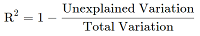

R-squared values range from 0 to 1 and are commonly stated as percentages from 0% to 100% where 100% means that all movements of a dependent variable are completely explained by movements in the independent variable(s) you are interested in.

#### To Do List:
- Imports
- Clean the data if need be
- Visualize the data and relationships
- Start building models
- Fine tune the models
- Find the best models for the datasets
- Compare the test data and the predictions

In [1]:
# Importing required libraries.
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
#Read-in 2019 Pitching Data
df = pd.read_csv('data/pitching_data/mlb-pitching-2019.csv', index_col='Player')
df.head()

,Team,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP
Player,,,,,,,,,,,,,,,,,,,
Justin Verlander,HOU,37,34,34,2,1,223.0,137,64,300,42,36,21,6,0,0,0,2.58,0.80
Shane Bieber,CLE,25,34,33,3,2,214.1,186,78,259,40,31,15,8,0,0,0,3.28,1.05
Gerrit Cole,HOU,29,33,33,0,0,212.1,142,59,326,48,29,20,5,0,0,0,2.50,0.89
Stephen Strasburg,WAS,32,33,33,0,0,209.0,161,77,251,56,24,18,6,0,0,0,3.32,1.04
Mike Minor,TEX,32,32,32,2,1,208.1,190,83,200,68,30,14,10,0,0,0,3.59,1.24


In [3]:
#Describe Data
df.describe()

,Age,G,GS,CG,SHO,IP,H,ER,K,BB,HR,W,L,SV,BS,HLD,ERA,WHIP
count,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000,872.000000
mean,29.049312,24.470183,5.571101,0.051606,0.029817,49.449541,48.061927,24.824541,49.074541,18.172018,7.733945,2.785550,2.784404,1.352064,0.787844,2.815367,5.901456,1.568979
std,3.517527,19.554018,9.612563,0.280801,0.189339,49.913335,47.576281,23.209626,51.865699,16.011125,7.812989,3.696726,3.237884,5.039786,1.519015,5.455095,7.724401,1.072112
min,20.000000,1.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,9.000000,0.000000,0.000000,0.000000,13.000000,14.000000,8.000000,11.000000,6.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.647500,1.220000
50%,29.000000,20.000000,0.000000,0.000000,0.000000,33.100000,33.000000,17.000000,31.500000,13.500000,5.000000,1.000000,2.000000,0.000000,0.000000,0.000000,4.750000,1.410000
75%,31.000000,33.000000,7.000000,0.000000,0.000000,65.025000,62.000000,33.000000,69.250000,26.000000,10.000000,4.000000,4.000000,0.000000,1.000000,3.000000,6.390000,1.680000
max,43.000000,83.000000,34.000000,3.000000,2.000000,223.000000,225.000000,110.000000,326.000000,86.000000,39.000000,21.000000,17.000000,41.000000,9.000000,31.000000,162.000000,21.000000


In [4]:
#Get info on the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, Justin Verlander to Taylor Hearn
Data columns (total 19 columns):
Team    872 non-null object
Age     872 non-null int64
G       872 non-null int64
GS      872 non-null int64
CG      872 non-null int64
SHO     872 non-null int64
IP      872 non-null float64
H       872 non-null int64
ER      872 non-null int64
K       872 non-null int64
BB      872 non-null int64
HR      872 non-null int64
W       872 non-null int64
L       872 non-null int64
SV      872 non-null int64
BS      872 non-null int64
HLD     872 non-null int64
ERA     872 non-null float64
WHIP    872 non-null float64
dtypes: float64(3), int64(15), object(1)
memory usage: 136.2+ KB


In [5]:
#Drop Team Column
df = df.drop(['Team'], axis=1)

In [6]:
#Get info on the Data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 872 entries, Justin Verlander to Taylor Hearn
Data columns (total 18 columns):
Age     872 non-null int64
G       872 non-null int64
GS      872 non-null int64
CG      872 non-null int64
SHO     872 non-null int64
IP      872 non-null float64
H       872 non-null int64
ER      872 non-null int64
K       872 non-null int64
BB      872 non-null int64
HR      872 non-null int64
W       872 non-null int64
L       872 non-null int64
SV      872 non-null int64
BS      872 non-null int64
HLD     872 non-null int64
ERA     872 non-null float64
WHIP    872 non-null float64
dtypes: float64(3), int64(15)
memory usage: 129.4+ KB


## Correlation Matrix

Now that the data is clean and we have verified they are all non-null and formatted numbers, we can visualize the correlation matrix for the various pieces of data.

In [22]:
# Correlation Matrix of quantitative features
c = df.corr()

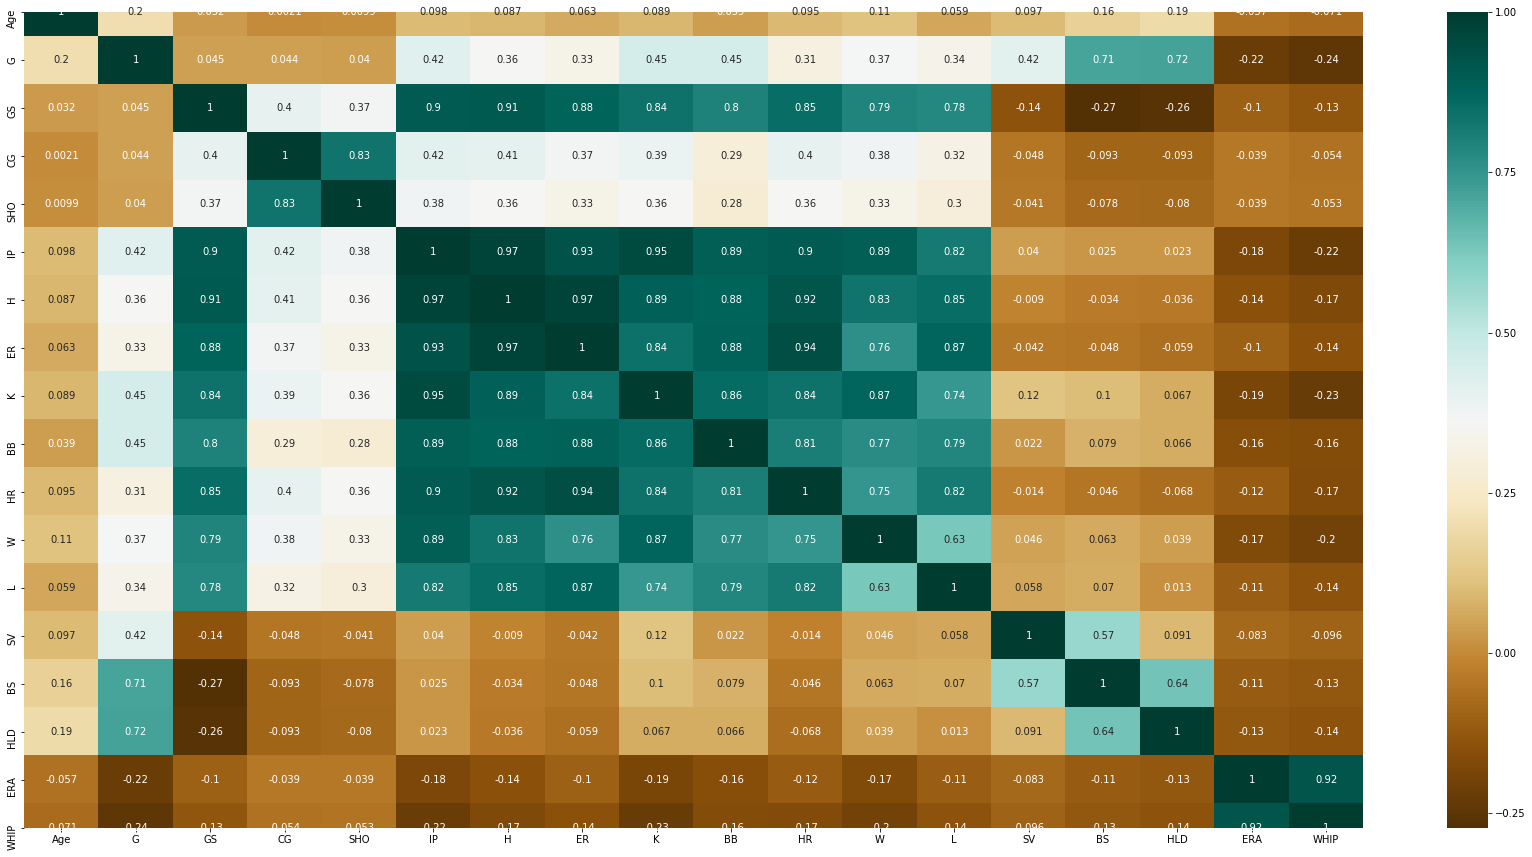

In [23]:
#visualizing the correlation matrix
plt.figure(figsize=(30,15))
sns.heatmap(c,cmap="BrBG", annot=True)

In [24]:
# Getting Features that have a correlation of greater than 0.5 for model building
selected_features = []
for i in range(len(c['W'])):
  if c['W'].values[i] >= 0.5 and c['W'].values[i] != 1.0:
    selected_features.append(c['W'].index[i])
  
selected_features

['GS', 'IP', 'H', 'ER', 'K', 'BB', 'HR', 'L']

In [10]:
#Required Imports
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor

In [11]:
X = df[selected_features]
y = df.W

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .20)

In [13]:
# Linear Regression Pipeline
lr = Pipeline(steps=[('LinReg', LinearRegression())])
lr.fit(X_train, y_train)

lr_preds = lr.predict(X_test)
print(f'Linear Regression model R2 score:  {r2_score(y_test, lr_preds)}')

Linear Regression model R2 score:  0.73625019852485


In [14]:
#Hyperparameter optimization for DecisionTreeRegressor
parameters = {
    'max_depth':[15,20,30],
}
dtc = Pipeline(steps=[('CV',GridSearchCV(DecisionTreeRegressor(), parameters, cv = 5))])
dtc.fit(X_train, y_train)
dtc.named_steps['CV'].best_params_

{'max_depth': 30}

In [25]:
# DecisionTrees pipeline 
dt = Pipeline(steps=[('LogReg', DecisionTreeRegressor(max_depth=15))])
dt.fit(X_train,y_train)
dt_preds = dt.predict(X_test)
print(f'Decision Trees model R2 score:  {r2_score(y_test, dt_preds)}')

Decision Trees model R2 score:  0.5604636790396248


In [16]:
# Hyperparameter optimization of RandomForestClassifier
parameters = {
    'max_depth':[6,12,15,20],
    'n_estimators':[20,30]
}
rfc = Pipeline([('CV',GridSearchCV(RandomForestRegressor(), parameters, cv = 5))])
rfc.fit(X_train, y_train)
rfc.named_steps['CV'].best_params_

{'max_depth': 6, 'n_estimators': 30}

In [26]:
# RandomForestTrees pipeline 
rf = Pipeline(steps=[('LogReg', RandomForestRegressor(max_depth=6,n_estimators=30))])
rf.fit(X_train,y_train)
rf_preds = rf.predict(X_test)
print(f'Random Forest model R2 score:  {r2_score(y_test,rf_preds)}')

Random Forest model R2 score:  0.7517111539930194


# Making predictions using Linear Regression model
Linear Regression scored the best out of the 3 models we tested.

In [18]:
y_pred = rf.predict(X)

In [19]:
predictions_df = pd.DataFrame({'Real W':df.W, 'Predicted W':y_pred})

In [20]:
predictions_df.head()

,Real W,Predicted W
Player,,
Justin Verlander,21,19.422222
Shane Bieber,15,14.533611
Gerrit Cole,20,19.055556
Stephen Strasburg,18,18.293333
Mike Minor,14,13.891817


In [21]:
# Exporting Model for later use
import pickle

filename = 'lr_pitching_model.sav'
pickle.dump(rf, open(filename, 'wb'))